### Comparing Network Subgroups

In [1]:
import traceback

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from hiveplotlib import Axis, HivePlot, Node, hive_plot_n_axes
from hiveplotlib.viz import axes_viz, edge_viz, hive_plot_viz, node_viz
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

%matplotlib inline

#### Motivation

The discussion of hive plots in the documentation so far focuses on variability solely between groups of nodes separated by axes. This is a perfectly valid and interesting means of comparison; however, there's nothing stopping us from considering additional variability. In this notebook, we contemplate one specific form of variability:

> _**What if we want to compare multiple subgroups embedded in 1 network?**_

One option to address this question is simply to make multiple figures (e.g. 1 plot per subgroup). This implementation doesn't require any more advanced use of `hiveplotlib` than covered in other notebooks, only requiring a `for` loop to generate multiple Hive Plots.

When one has a sufficiently small number of groups though, it can be useful to visualize these groups superimposed on top of each other in a single hive plot, which can visually flaunt the variability between groups. This technique requires some slightly modified bookkeeping in `hiveplotlib`, essentially tracking _tags_ of edge sets in a `HivePlot` instance, along with specifying kwargs for different tags of edges.

In this notebook, we cover the high-level and low-level function calls for visualizing multiple subgroups in a single hive plot.

#### Toy Example: Employee Interactions

To better motivate this concept, let's consider a fabricated example. Suppose say we have 3 divisions of employees, _D1, D2, D3_, and we are interested in focusing on the interactions between employees with respect to their seniority at the company.

We will contrive a problem at this company: employees generally only interact with employees of similar seniority.

In [2]:
# generating toy example
rng = np.random.default_rng(0)

# only interactions between individuals
#  with a seniority difference below this threshold
seniority_diff_threshold = 1

num_nodes_per_division = 50

# 3 divisions, random uniform value for seniority at company
d1 = np.sort(rng.uniform(low=2, high=10, size=num_nodes_per_division))
d2 = np.sort(rng.uniform(low=2, high=10, size=num_nodes_per_division))
d3 = np.sort(rng.uniform(low=2, high=10, size=num_nodes_per_division))

# organize data into Node instances
node_data = np.r_[d1, d2, d3]
nodes = [Node(unique_id=i, data={"seniority": dat}) for i, dat in enumerate(node_data)]

# produce edges where each node is close in seniority
num_edges = 200

start_edges = rng.choice(node_data.size, size=num_edges)

stop_edges = []
for e in start_edges:
    start_seniority = nodes[e].data["seniority"]
    # draw edge endpoints until sufficiently close in seniority
    while True:
        proposed_stop_edge = rng.choice(node_data.size)
        stop_seniority = nodes[proposed_stop_edge].data["seniority"]
        seniority_diff = np.abs(stop_seniority - start_seniority)
        if seniority_diff <= seniority_diff_threshold:
            break
    stop_edges.append(proposed_stop_edge)

edges = np.c_[start_edges, stop_edges]

# partition Node IDs back to their respective Divisions
axes_assignments = np.split(np.arange(num_nodes_per_division * 3), 3)

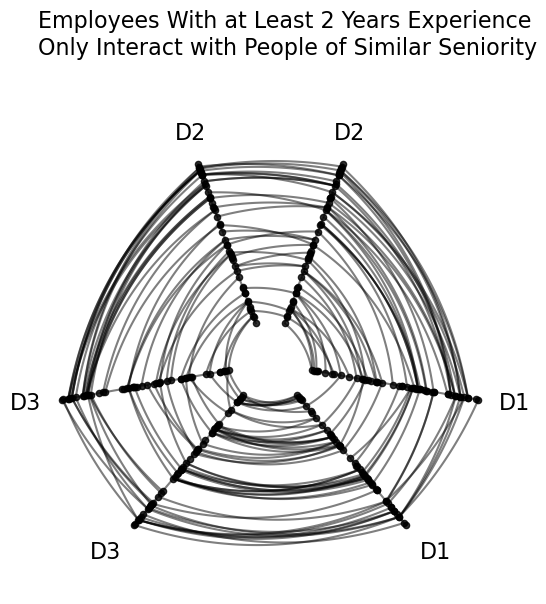

In [3]:
hp = hive_plot_n_axes(
    node_list=nodes,
    edges=edges,
    axes_assignments=axes_assignments,
    sorting_variables=["seniority"] * 3,
    axes_names=["D1", "D2", "D3"],
    repeat_axes=["True"] * 3,
    orient_angle=-30,
)

fig, ax = hive_plot_viz(hp, figsize=(6, 6))

ax.set_title(
    "Employees With at Least 2 Years Experience\n"
    "Only Interact with People of Similar Seniority",
    y=1.15,
    size=16,
    loc="left",
)
plt.show()

In the above figure, the "concentric circles" look of edges is to be expected from our toy setup: if all axes are sorted on seniority, and these employees only interact with people of similar seniority, then edges should connect at similar points on each axis. 

#### Considering a Second Group in the Same Figure 

Suppose there had been a successful revision to the training program 2 years ago that encouraged more communication throughout the company regardless of seniority. With two sets of nodes and edges, we can quickly concatenate the two sets of network information into a single `HivePlot` instance that visualizes both groups in comparison to each other.

In [4]:
# generating second set of data
rng = np.random.default_rng(0)

num_nodes_per_division_new = 10

# still 3 divisions, "new" employees all within the last 2 years
#  (still random uniform value for seniority at company)
d1_new = np.sort(rng.uniform(low=0, high=2, size=num_nodes_per_division_new))
d2_new = np.sort(rng.uniform(low=0, high=2, size=num_nodes_per_division_new))
d3_new = np.sort(rng.uniform(low=0, high=2, size=num_nodes_per_division_new))

# organize data into Node instances
node_data_new = np.r_[d1_new, d2_new, d3_new]

# make sure IDs are unique with respect to ALL IDs
#  (e.g. start counting indices past original nodes)
nodes_new = [
    Node(unique_id=i + node_data.size, data={"seniority": dat})
    for i, dat in enumerate(node_data_new)
]

# produce edges no longer contingent on seniority
num_edges_new = 50

# new start edge IDs all begin after the original node instances
start_edges_new = rng.choice(node_data_new.size, size=num_edges_new) + node_data.size

# new employees will interact with anyone
stop_edges_new = rng.choice(node_data_new.size + node_data.size, size=num_edges_new)
edges_new = np.c_[start_edges_new, stop_edges_new]

# partition new Node IDs to their respective Divisions
axes_assignments_new = np.split(
    np.arange(num_nodes_per_division_new * 3) + num_nodes_per_division * 3, 3
)

# compose new node axis assignments with old node axis assignments
axes_assignments_all = [
    np.r_[axes_assignments[i], axes_assignments_new[i]] for i in range(3)
]

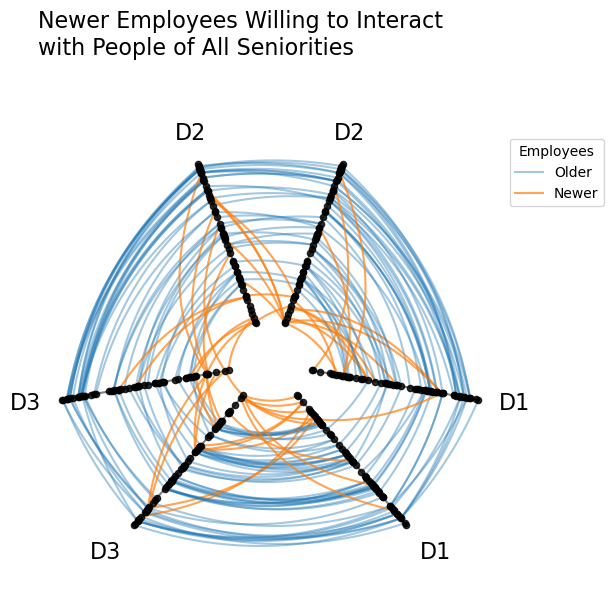

In [5]:
# specify how we want to style edges of each group in the final plot
older_employee_kwargs = {"color": "C0", "alpha": 0.4}
newer_employee_kwargs = {"color": "C1", "alpha": 0.7}

# same setup as before, just add all nodes at once,
#  but now a *list* of edge arrays,
#  and a *list* of distinct kwargs for each set of edges
hp_new = hive_plot_n_axes(
    node_list=nodes + nodes_new,
    edges=[edges, edges_new],  # note this is now a list
    axes_assignments=axes_assignments_all,
    sorting_variables=["seniority"] * 3,
    axes_names=["D1", "D2", "D3"],
    edge_list_kwargs=[older_employee_kwargs, newer_employee_kwargs],
    repeat_axes=["True"] * 3,
    orient_angle=-30,
)

fig, ax = hive_plot_viz(hp_new, figsize=(6, 6))

ax.set_title(
    "Newer Employees Willing to Interact\n" "with People of All Seniorities",
    y=1.15,
    size=16,
    loc="left",
)

# custom legend
custom_lines = [
    Line2D([0], [0], **older_employee_kwargs),
    Line2D([0], [0], **newer_employee_kwargs),
]
ax.legend(
    custom_lines,
    ["Older", "Newer"],
    title="Employees",
    loc="upper left",
    bbox_to_anchor=(1, 1),
)
plt.show()

In the above figure, we can clearly see that the newer employee interactions (orange) do not obey the concentric circle structure followed by older employee interactions (blue). Unlike older employees, newer employees choose to interact with employees of varying seniorities.

We have thus visualized the heterogeneous behavior between two sets of nodes in a single network on one set of axes.

#### Lower-level Functionality

Adding a distinctly-colored set of edges in a `HivePlot` instance mostly follows the same conventions in `hiveplotlib` discussed elsewhere, with the exception that we must now introuduce the `tag` parameter. _Tagging_ a set of edges between 2 axes allows us to reference that unique subset of edges for modification later.

In practice, all the method calls are the same, only we need to start specifying tags in the calls once we have more than one set of tags between a pair of axes.

As an example, let's replicate a subset of the above Hive Plot, looking just at the axis pair $(D1, D2)$.

In [6]:
axis_d1 = Axis(axis_id="D1", start=1, end=5, angle=-10)
axis_d2 = Axis(axis_id="D2", start=1, end=5, angle=70)

# we'll include all the nodes for ease of adding, but
#  we'll only *place* all of the D1 and D2 nodes
node_list = nodes + nodes_new

hp = HivePlot()
hp.add_nodes(node_list)
hp.add_axes([axis_d1, axis_d2])

hp.place_nodes_on_axis(
    axis_id="D1", unique_ids=axes_assignments_all[0], sorting_feature_to_use="seniority"
)
hp.place_nodes_on_axis(
    axis_id="D2", unique_ids=axes_assignments_all[1], sorting_feature_to_use="seniority"
)

Up to this point, the code has been the same as if we were making a standard Hive Plot with one color of edges. It is only when we start _connecting_  the axes (e.g. creating edges which we will reference later) that we start to use the `tag` parameter.

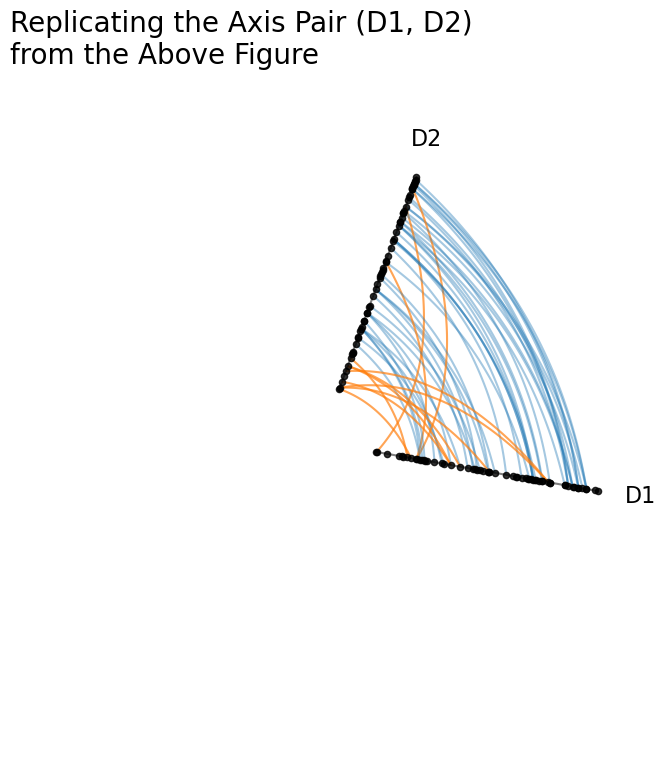

In [7]:
hp.connect_axes(
    edges=edges, tag="Older", axis_id_1="D1", axis_id_2="D2", **older_employee_kwargs
)
hp.connect_axes(
    edges=edges_new,
    tag="Newer",
    axis_id_1="D1",
    axis_id_2="D2",
    **newer_employee_kwargs,
)

# lower-level viz is the same as before
fig, ax = axes_viz(hp, figsize=(8, 8))
node_viz(hp, fig=fig, ax=ax, color="black", s=20, alpha=0.8)
edge_viz(hp, fig=fig, ax=ax, zorder=-1)
ax.set_title(
    "Replicating the Axis Pair (D1, D2)\n" "from the Above Figure",
    y=1.1,
    fontsize=20,
    loc="left",
)
plt.show()

If we want to modify our kwargs, we can now reference edges by their `tag` values.

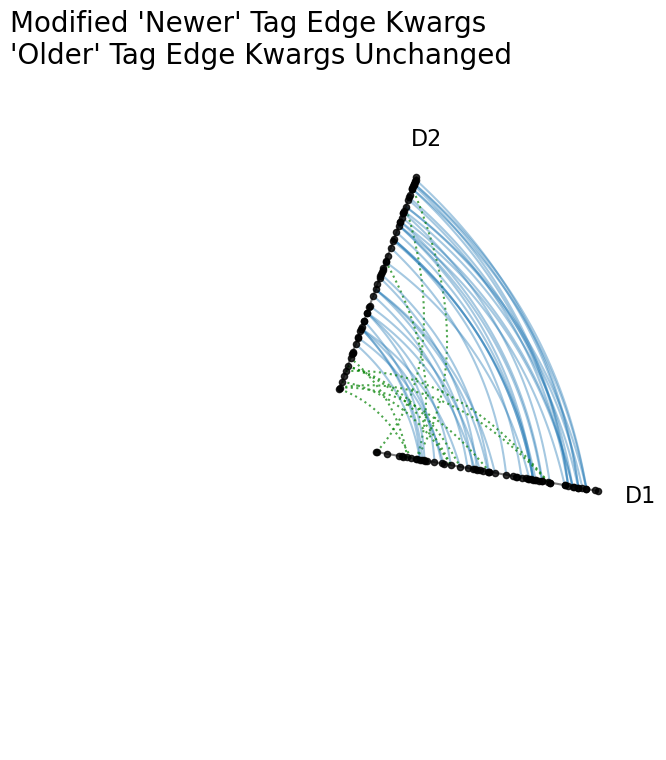

In [8]:
# modify *just* the "Newer" tag's kwargs
hp.add_edge_kwargs(
    axis_id_1="D1", axis_id_2="D2", tag="Newer", color="green", ls="dotted"
)

fig, ax = hive_plot_viz(hp, figsize=(8, 8))
ax.set_title(
    "Modified 'Newer' Tag Edge Kwargs\n" "'Older' Tag Edge Kwargs Unchanged",
    y=1.1,
    fontsize=20,
    loc="left",
)
plt.show()

#### When Are Tags Needed?

You may be wondering how your code has been working _without_ these tags up to this point.

Even if not specified, tags are automatically generated when edges are added to a pair of axes. When there is only one tag of edges between two axes, there's no ambiguity to which edges the user wishes to modify, so `HivePlot` methods easily infer where to take action.


Once a second tag of edges exists between two axes though, tags will be required to modify edges.

As an example, below we'll add one at a time the same two sets of edges as before. This time, however, we'll try to modify the edge kwargs without specifying tags, both when there's one tag of edges and when there's two tags of edges, to see the error generated by tag ambiguity.

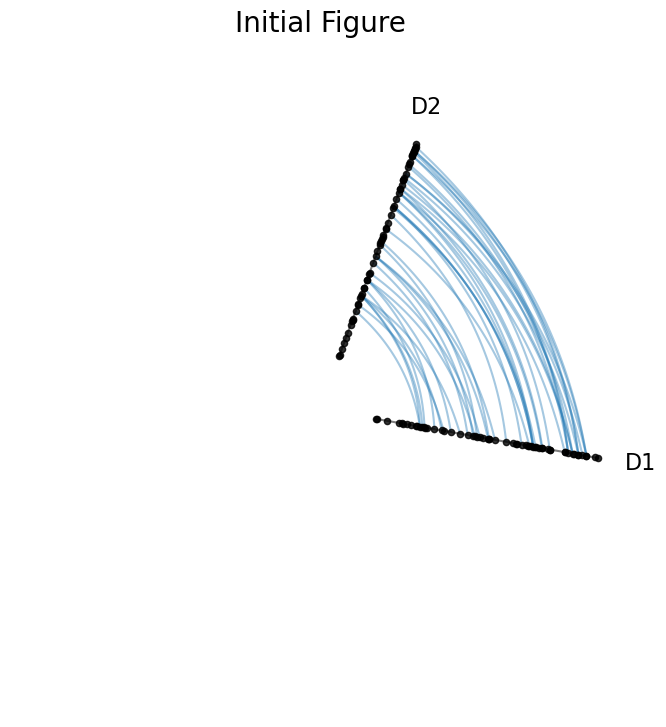

In [9]:
hp_copy = hp.copy()

# delete *just* the new employee edges
#  leaving only 1 tag of edges
hp_copy.reset_edges(axis_id_1="D1", axis_id_2="D2", tag="Newer")
fig, ax = hive_plot_viz(hp_copy, figsize=(8, 8))
ax.set_title("Initial Figure", y=1.1, fontsize=20)
plt.show()

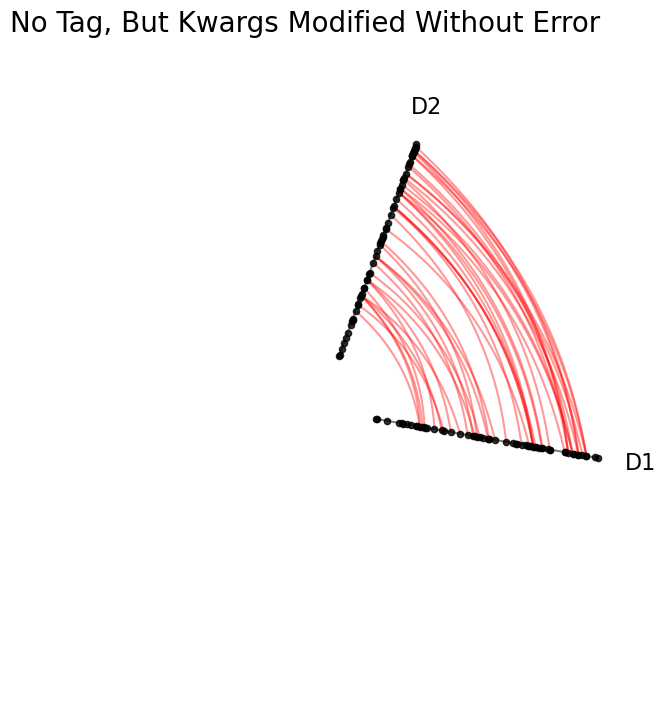

In [10]:
# modify kwargs when there's only 1 tag
#  (without specifying tag)
hp_copy.add_edge_kwargs(axis_id_1="D1", axis_id_2="D2", color="red")
fig, ax = hive_plot_viz(hp_copy, figsize=(8, 8))
ax.set_title(
    "No Tag, But Kwargs Modified Without Error", y=1.1, fontsize=20, loc="left"
)
plt.show()

In [11]:
# add back in the second tag
hp_copy.connect_axes(
    edges=edges_new,
    tag="Newer",
    axis_id_1="D1",
    axis_id_2="D2",
    **newer_employee_kwargs,
)

# try and modify just the older edges again
#  (without specifying tag)
try:
    hp_copy.add_edge_kwargs(axis_id_1="D1", axis_id_2="D2", color="purple")
except ValueError:
    print("Once we have 2 tags, " "a lack of tag specification triggers an error\n")
    print(traceback.format_exc())

Once we have 2 tags, a lack of tag specification triggers an error

Traceback (most recent call last):
  File "/tmp/ipykernel_3454206/1178127476.py", line 13, in <module>
    hp_copy.add_edge_kwargs(axis_id_1="D1", axis_id_2="D2", color="purple")
  File "/home/gary.koplik/repos/hiveplotlib/src/hiveplotlib/hiveplot.py", line 956, in add_edge_kwargs
    raise ValueError(
ValueError: Must specify precise `tag` to handle both `a1_to_a2=True` and `a2_to_a1=True` here. The current tags for the specified axes are:
D2 -> D1: ['Older', 'Newer']
D2 -> D1: ['Older', 'Newer']



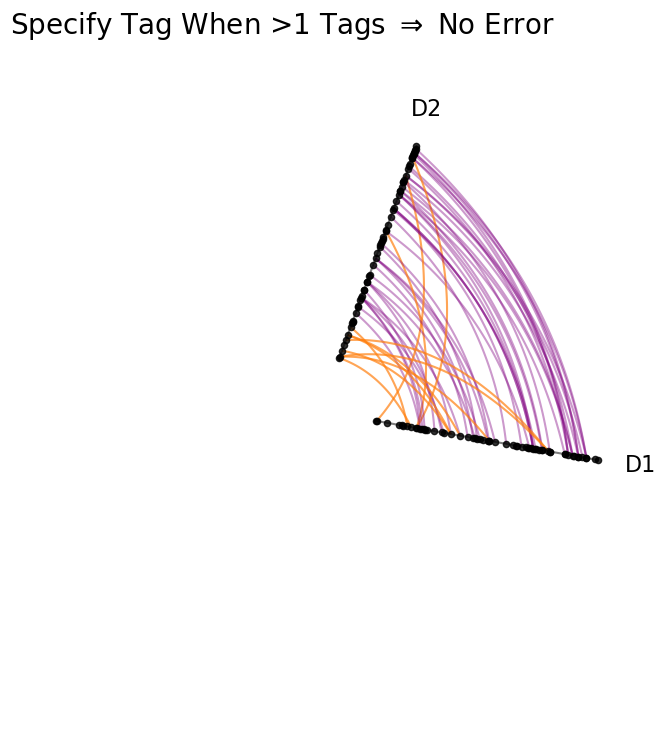

In [12]:
# modify same as above, but include tag
hp_copy.add_edge_kwargs(axis_id_1="D1", axis_id_2="D2", tag="Older", color="purple")
fig, ax = hive_plot_viz(hp_copy, figsize=(8, 8))
ax.set_title(
    r"Specify Tag When >1 Tags $\Rightarrow$ No Error", y=1.1, fontsize=20, loc="left"
)
plt.show()

#### Autogenerated Tags on Edges

Specific tags can be added by users mainly to make the code more human-readable, but in relatively automated circumstances, one can simply let tags autogenerate and store them for reference later, due to these tags being returned by the `connect_axes()` method call.

As an example, below we draw only the "Older" edges from the earlier figure, but here we'll instead tag each of those edges separately and change each of them over a loop rather than one at a time.

Autogenerated tags:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


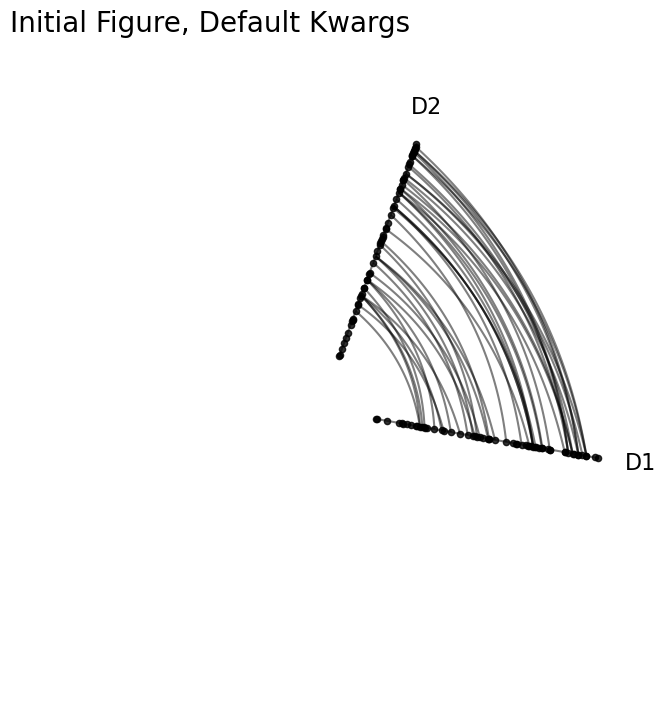

In [13]:
hp_copy = hp.copy()

# delete all edges
hp_copy.reset_edges()

tags = []

# add just the "Older" edges back, but one at a time
#  storing autogenerated tags as we go
for e in list(edges):
    # grab the tag returned from calling `connect_axes()`
    t = hp_copy.connect_axes(edges=e.reshape(1, 2), axis_id_1="D1", axis_id_2="D2")
    tags.append(t)

print(f"Autogenerated tags:\n{tags}")

fig, ax = hive_plot_viz(hp_copy, figsize=(8, 8))
ax.set_title("Initial Figure, Default Kwargs", y=1.1, fontsize=20, loc="left")
plt.show()

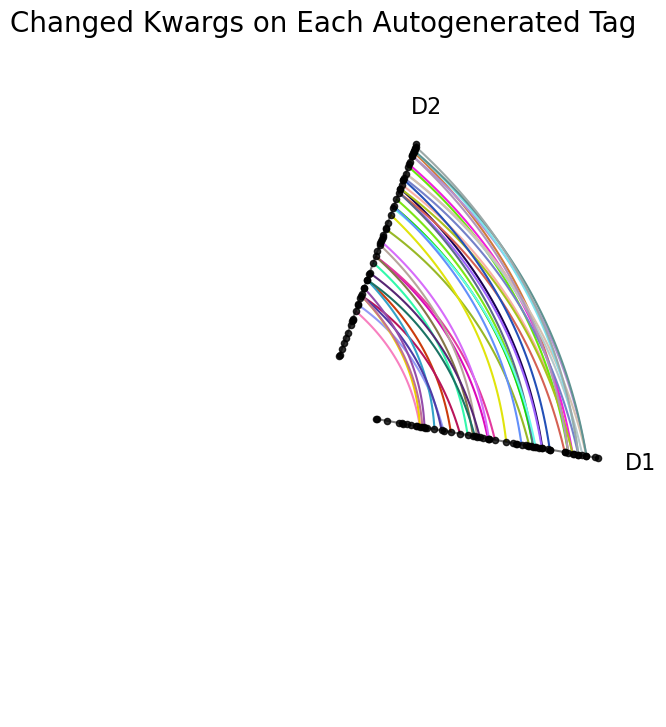

In [14]:
rng = np.random.default_rng(0)

# modify kwargs of each edge 1 at a time
for t in tags:
    hp_copy.add_edge_kwargs(
        axis_id_1="D1",
        axis_id_2="D2",
        tag=t,
        color=rng.random(
            3,
        ),
        alpha=1,
    )

fig, ax = hive_plot_viz(hp_copy, figsize=(8, 8))
ax.set_title("Changed Kwargs on Each Autogenerated Tag", y=1.1, fontsize=20, loc="left")
plt.show()

#### Scaling to Large Networks

As we scale to larger networks, our ability to compose different tags of data into a single hive plot visualization still works as expected computationally, but there are a couple of changes we should make to ensure our visualizations don't risk hiding information from us let alone actively mislead us.

Note: this section of the notebook requires that `hiveplotlib` be installed with the `datashader` package, which can be done by running:

> `pip install hiveplotlib[datashader]`.

In [15]:
from hiveplotlib.viz.datashader import datashade_edges_mpl

##### Oversaturation Concerns

The many overlapping lines of a hive plot risks [oversaturation](https://datashader.org/user_guide/Plotting_Pitfalls.html#oversaturation) issues, which could mislead us if we were to try to draw conclusions from exploratory visualizations.

To demonstrate, let's take the above example from this notebook and see what happens when we scale up the dataset. We will first choose our kwargs using the `hiveplotlib` defaults and then choose kwargs knowing the ground truth story that we designed into our data.

In [16]:
# generating toy example
rng = np.random.default_rng(0)

# only interactions between individuals
#  with a seniority difference below this threshold
seniority_diff_threshold = 1

num_nodes_per_division = 500

# 3 divisions, random uniform value for seniority at company
d1 = np.sort(rng.uniform(low=2, high=10, size=num_nodes_per_division))
d2 = np.sort(rng.uniform(low=2, high=10, size=num_nodes_per_division))
d3 = np.sort(rng.uniform(low=2, high=10, size=num_nodes_per_division))

# organize data into Node instances
node_data = np.r_[d1, d2, d3]
nodes = [Node(unique_id=i, data={"seniority": dat}) for i, dat in enumerate(node_data)]

# produce edges where each node is close in seniority
num_edges = 20000

start_edges = rng.choice(node_data.size, size=num_edges)

stop_edges = []
for e in start_edges:
    start_seniority = nodes[e].data["seniority"]
    # draw edge endpoints until sufficiently close in seniority
    while True:
        proposed_stop_edge = rng.choice(node_data.size)
        stop_seniority = nodes[proposed_stop_edge].data["seniority"]
        seniority_diff = np.abs(stop_seniority - start_seniority)
        if seniority_diff <= seniority_diff_threshold:
            break
    stop_edges.append(proposed_stop_edge)

edges = np.c_[start_edges, stop_edges]

# partition Node IDs back to their respective Divisions
axes_assignments = np.split(np.arange(num_nodes_per_division * 3), 3)

# generating second set of data
rng = np.random.default_rng(0)

num_nodes_per_division_new = 100

# still 3 divisions, "new" employees all within the last 2 years
#  (still random uniform value for seniority at company)
d1_new = np.sort(rng.uniform(low=0, high=2, size=num_nodes_per_division_new))
d2_new = np.sort(rng.uniform(low=0, high=2, size=num_nodes_per_division_new))
d3_new = np.sort(rng.uniform(low=0, high=2, size=num_nodes_per_division_new))

# organize data into Node instances
node_data_new = np.r_[d1_new, d2_new, d3_new]

# make sure IDs are unique with respect to ALL IDs
#  (e.g. start counting indices past original nodes)
nodes_new = [
    Node(unique_id=i + node_data.size, data={"seniority": dat})
    for i, dat in enumerate(node_data_new)
]

# produce edges no longer contingent on seniority
num_edges_new = 5000

# new start edge IDs all begin after the original node instances
start_edges_new = rng.choice(node_data_new.size, size=num_edges_new) + node_data.size

# new employees will interact with anyone
stop_edges_new = rng.choice(node_data_new.size + node_data.size, size=num_edges_new)
edges_new = np.c_[start_edges_new, stop_edges_new]

# partition new Node IDs to their respective Divisions
axes_assignments_new = np.split(
    np.arange(num_nodes_per_division_new * 3) + num_nodes_per_division * 3, 3
)

# compose new node axis assignments with old node axis assignments
axes_assignments_all = []
for i in range(3):
    axes_assignments_all.append(np.r_[axes_assignments[i], axes_assignments_new[i]])

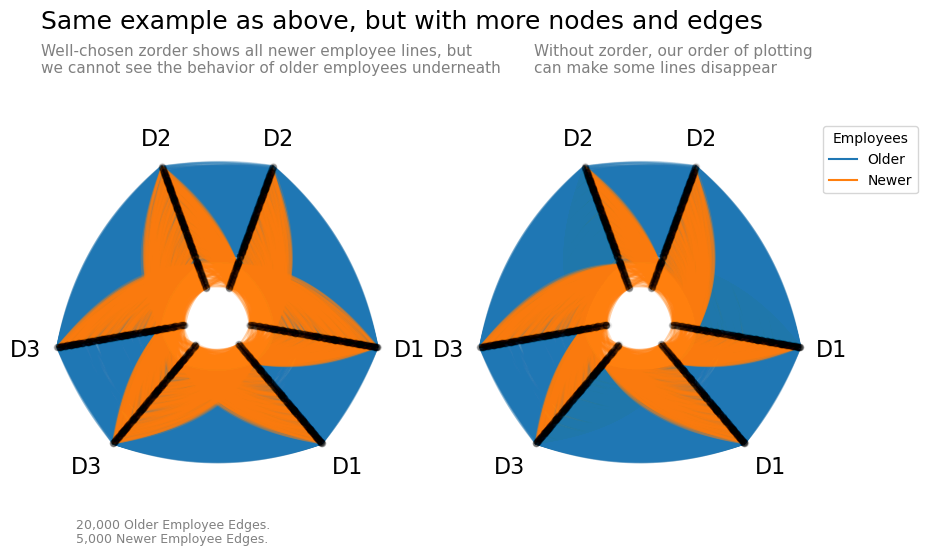

In [17]:
# specify how we want to style edges of each group in the final plot
older_employee_kwargs = {"color": "C0", "alpha": 0.1, "zorder": 2}
newer_employee_kwargs = {"color": "C1", "alpha": 0.2, "zorder": 3}

# same setup as before, just add all nodes at once,
#  but now a *list* of edge arrays,
#  and a *list* of distinct kwargs for each set of edges
hp_new = hive_plot_n_axes(
    node_list=nodes + nodes_new,
    edges=[edges, edges_new],  # note this is now a list
    axes_assignments=axes_assignments_all,
    sorting_variables=["seniority"] * 3,
    axes_names=["D1", "D2", "D3"],
    edge_list_kwargs=[older_employee_kwargs, newer_employee_kwargs],
    repeat_axes=["True"] * 3,
    orient_angle=-30,
)

# count how many edges go in our final hive plot
total_edges = [0, 0]
for g1 in hp_new.edges:
    for g2 in hp_new.edges[g1]:
        for tag in hp_new.edges[g1][g2]:
            total_edges[tag] += hp_new.edges[g1][g2][tag]["ids"].shape[0]


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
hive_plot_viz(hp_new, fig=fig, ax=ax[0], node_kwargs={"alpha": 0.05})

ax[0].set_title(
    "Well-chosen zorder shows all newer employee lines, but\n"
    "we cannot see the behavior of older employees underneath",
    y=1.1,
    size=11,
    loc="left",
    color="gray",
)


# recreate hive plot without strategic zorder
del older_employee_kwargs["zorder"]
del newer_employee_kwargs["zorder"]

hp_new = hive_plot_n_axes(
    node_list=nodes + nodes_new,
    edges=[edges, edges_new],  # note this is now a list
    axes_assignments=axes_assignments_all,
    sorting_variables=["seniority"] * 3,
    axes_names=["D1", "D2", "D3"],
    edge_list_kwargs=[older_employee_kwargs, newer_employee_kwargs],
    repeat_axes=["True"] * 3,
    orient_angle=-30,
)

hive_plot_viz(hp_new, fig=fig, ax=ax[1], node_kwargs={"alpha": 0.05}, zorder=2)

ax[1].set_title(
    "Without zorder, our order of plotting\ncan make some lines disappear",
    y=1.1,
    size=11,
    x=0.2,
    ha="left",
    color="gray",
)


fig.suptitle(
    "Same example as above, but with more nodes and edges",
    x=0.125,
    y=1.1,
    size=18,
    ha="left",
)

# custom legend
custom_lines = [
    Line2D([0], [0], color=older_employee_kwargs["color"]),
    Line2D([0], [0], color=newer_employee_kwargs["color"]),
]
ax[1].legend(
    custom_lines,
    ["Older", "Newer"],
    title="Employees",
    loc="upper left",
    bbox_to_anchor=(1, 1),
)

ax[0].axis("equal")
ax[1].axis("equal")
ax[0].text(
    x=0.1,
    y=-0.1,
    s=f"{total_edges[0]:,} Older Employee Edges.\n"
    f"{total_edges[1]:,} Newer Employee Edges.",
    size=9,
    color="gray",
    ha="left",
    transform=ax[0].transAxes,
)
plt.show()

When plotting so many lines, we are basically plotting filled polygons of data on top of each other. This makes comparing overlapping areas essentially impossible with one tag of data often hiding another overlapping tag's edges, as both plots in the above figure demonstrate.

Furthermore, the order of operations when plotting risks misleading us. In the right plot of the above figure, we lose one direction of the intergroup newer employee edges underneath older employee edges, implying a nonexistent asymmetry of edges.

Although we of course still want to see these two tags of data on one figure to better compare them, we can protect ourselves against these issues by plotting each tag separately beforehand.

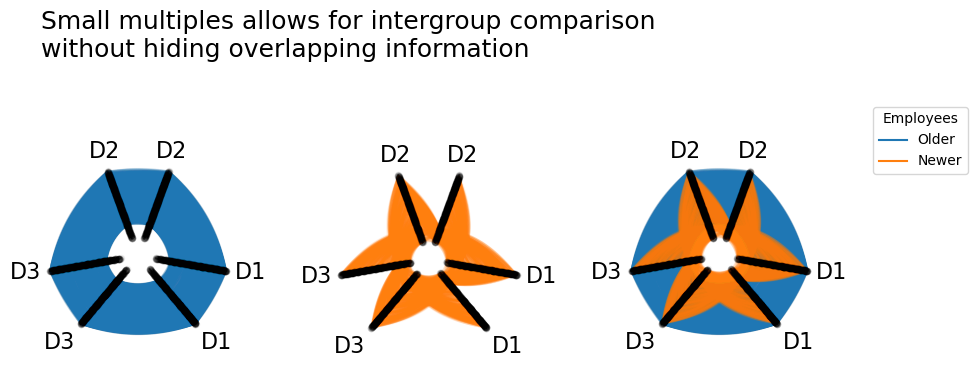

In [18]:
# specify how we want to style edges of each group in the final plot
older_employee_kwargs = {"color": "C0", "alpha": 0.05, "zorder": 2}
newer_employee_kwargs = {"color": "C1", "alpha": 0.1, "zorder": 3}

# same setup as before, just add all nodes at once,
#  but now a *list* of edge arrays,
#  and a *list* of distinct kwargs for each set of edges
hp_new = hive_plot_n_axes(
    node_list=nodes + nodes_new,
    edges=[edges, edges_new],  # note this is now a list
    axes_assignments=axes_assignments_all,
    sorting_variables=["seniority"] * 3,
    axes_names=["D1", "D2", "D3"],
    edge_list_kwargs=[older_employee_kwargs, newer_employee_kwargs],
    vmins=[0] * 3,  # keep vmin and vmax consistent amongst hive plots
    vmaxes=[10] * 3,
    repeat_axes=["True"] * 3,
    orient_angle=-30,
)

fig, ax = plt.subplots(1, 3, figsize=(10, 3))

for tags, a in zip([0, 1, [0, 1]], ax):
    hive_plot_viz(hp_new, fig=fig, ax=a, tags=tags, node_kwargs={"alpha": 0.05})

fig.suptitle(
    "Small multiples allows for intergroup comparison\n"
    "without hiding overlapping information",
    x=0.125,
    y=1.3,
    size=18,
    ha="left",
)

fig.subplots_adjust(wspace=0.5)

ax[0].axis("equal")
ax[1].axis("equal")
ax[2].axis("equal")

# custom legend
custom_lines = [
    Line2D([0], [0], color=older_employee_kwargs["color"]),
    Line2D([0], [0], color=newer_employee_kwargs["color"]),
]
fig.legend(
    custom_lines,
    ["Older", "Newer"],
    title="Employees",
    loc="upper left",
    bbox_to_anchor=(0.95, 1),
)

plt.show()

It is important to note that for these three hive plots, each axis extent (`vmin` and `vmax`) is held constant. This is critical to allow for a small multiples comparison between the three plots in the above figure. 

##### Datashading to Show Edge Density

Discussed in greater detail in the [Hive Plots for Large Networks notebook](https://geomdata.gitlab.io/hiveplotlib/hive_plots_for_large_networks.html), datashading allows for us to better visualize the relative density of edges on a figure regardless of the size of our network while also taking away the trial-and-error of playing with `linewidth` and `alpha` values.

To keep our figures consistent with past figures, below we first generate color maps for each tag of data based on their single color values above. Once we have those color maps, we can extend our small multiples visualization to datashade the edges.

In [19]:
color = "C1"
light = sns.light_palette(color, as_cmap=True)
dark = sns.dark_palette(color, reverse=True, as_cmap=True)

orange_cmap = ListedColormap(
    sns.color_palette(light(np.linspace(0.1, 1, int(0.9 / 1.4 * 256))))
    + sns.color_palette(dark(np.linspace(0, 0.5, int(0.5 / 1.4 * 256)))),
    name="Orange Color Map for Newer Employees",
)

color = "C0"
light = sns.light_palette(color, as_cmap=True)
dark = sns.dark_palette(color, reverse=True, as_cmap=True)

blue_cmap = ListedColormap(
    sns.color_palette(light(np.linspace(0.1, 1, int(0.9 / 1.4 * 256))))
    + sns.color_palette(dark(np.linspace(0, 0.5, int(0.5 / 1.4 * 256)))),
    name="Blue Color Map for Older Employees",
)

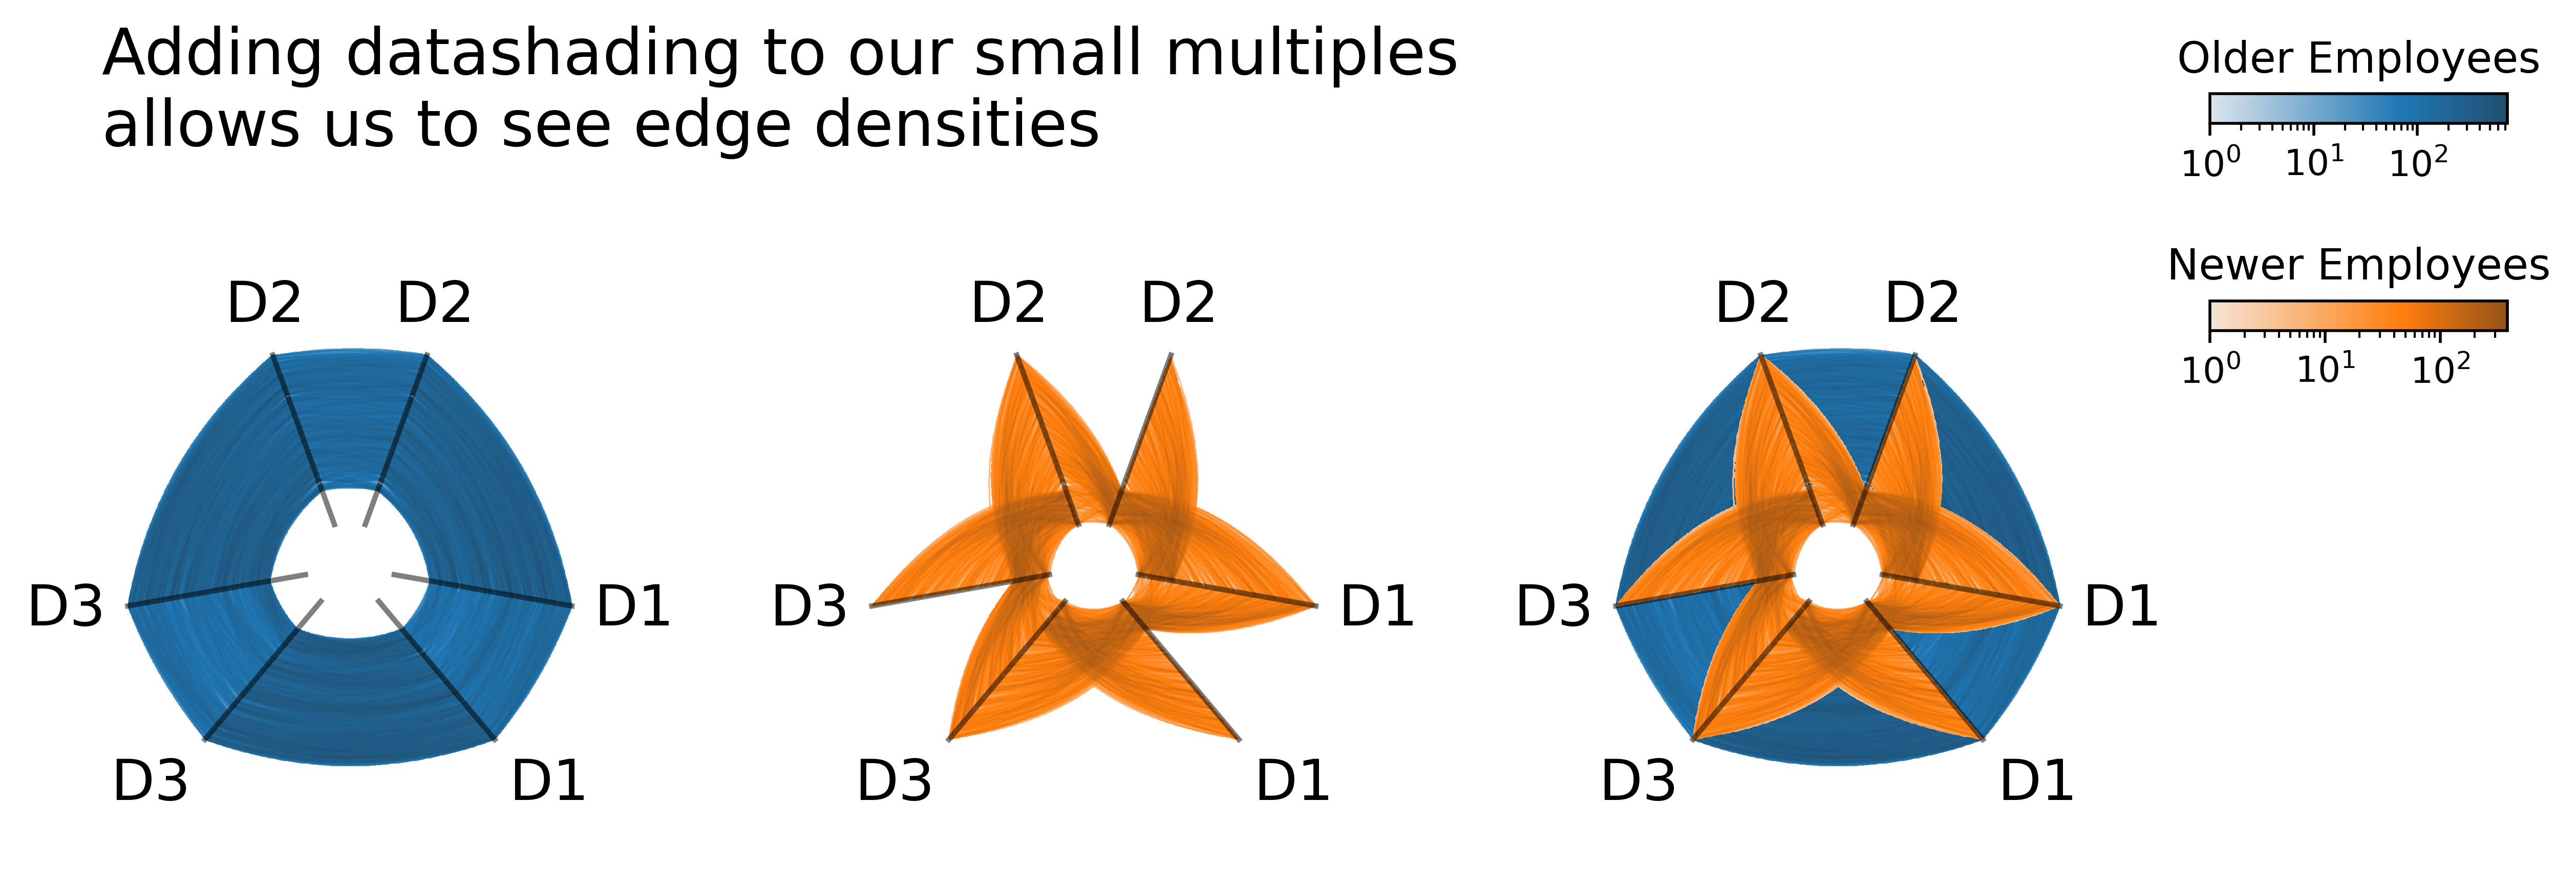

In [20]:
# same setup as before, just add all nodes at once,
#  but now a *list* of edge arrays,
#  and a *list* of distinct kwargs for each set of edges
hp_new = hive_plot_n_axes(
    node_list=nodes + nodes_new,
    edges=[edges, edges_new],  # note this is now a list
    axes_assignments=axes_assignments_all,
    sorting_variables=["seniority"] * 3,
    axes_names=["D1", "D2", "D3"],
    vmins=[0] * 3,  # keep vmin and vmax consistent amongst hive plots
    vmaxes=[10] * 3,
    repeat_axes=["True"] * 3,
    orient_angle=-30,
)

# smaller figures will datashade at higher resolution with higher dpi
fig, ax = plt.subplots(1, 3, figsize=(10, 3), dpi=500)

# put axes on each hive plot
for a in ax:
    axes_viz(hp_new, fig=fig, ax=a)

# older employees on first and third axis
for a in [ax[0], ax[2]]:
    _, _, blue_im = datashade_edges_mpl(hp_new, tag=0, fig=fig, ax=a, cmap=blue_cmap)

# newer employees on second and third axis
for a in [ax[1], ax[2]]:
    _, _, orange_im = datashade_edges_mpl(
        hp_new, tag=1, fig=fig, ax=a, cmap=orange_cmap
    )

fig.suptitle(
    "Adding datashading to our small multiples\n" "allows us to see edge densities",
    x=0.125,
    y=1.2,
    size=18,
    ha="left",
)

fig.subplots_adjust(wspace=0.5)

cax_blue = ax[2].inset_axes([1.25, 1.25, 0.6, 0.05], transform=ax[2].transAxes)
cb = fig.colorbar(blue_im, cax=cax_blue, orientation="horizontal")
cb.ax.set_title("Older Employees")

cax_orange = ax[2].inset_axes([1.25, 0.9, 0.6, 0.05], transform=ax[2].transAxes)
cb = fig.colorbar(orange_im, cax=cax_orange, orientation="horizontal")
cb.ax.set_title("Newer Employees")

plt.show()